<a href="https://www.kaggle.com/code/mahmoudabuelfadl/retail?scriptVersionId=246083514" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
#✅ Step 1: Import Required Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from xgboost import XGBRegressor, XGBClassifier
from scipy.stats import chi2_contingency
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load the Datasets
customers = pd.read_csv("/kaggle/input/retail-case-study-data/Customer.csv")
prod_cat_info = pd.read_csv("/kaggle/input/retail-case-study-data/Transactions.csv")
transactions = pd.read_csv("/kaggle/input/retail-case-study-data/prod_cat_info.csv")

In [3]:
# Check shapes
print("Customers:", customers.shape)
print("Product Categories:", prod_cat_info.shape)
print("Transactions:", transactions.shape)


Customers: (5647, 4)
Product Categories: (23053, 10)
Transactions: (23, 4)


In [4]:
# Preview data
customers.head()


,customer_Id,DOB,Gender,city_code
0,268408,02-01-1970,M,4.0
1,269696,07-01-1970,F,8.0
2,268159,08-01-1970,F,8.0
3,270181,10-01-1970,F,2.0
4,268073,11-01-1970,M,1.0


In [5]:
prod_cat_info.head()

,transaction_id,cust_id,tran_date,prod_subcat_code,prod_cat_code,Qty,Rate,Tax,total_amt,Store_type
0,80712190438,270351,28-02-2014,1,1,-5,-772,405.300,-4265.300,e-Shop
1,29258453508,270384,27-02-2014,5,3,-5,-1497,785.925,-8270.925,e-Shop
2,51750724947,273420,24-02-2014,6,5,-2,-791,166.110,-1748.110,TeleShop
3,93274880719,271509,24-02-2014,11,6,-3,-1363,429.345,-4518.345,e-Shop
4,51750724947,273420,23-02-2014,6,5,-2,-791,166.110,-1748.110,TeleShop


In [6]:
transactions.head()

,prod_cat_code,prod_cat,prod_sub_cat_code,prod_subcat
0,1,Clothing,4,Mens
1,1,Clothing,1,Women
2,1,Clothing,3,Kids
3,2,Footwear,1,Mens
4,2,Footwear,3,Women


In [7]:
# Info & nulls
customers.info()
prod_cat_info.info()
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5647 entries, 0 to 5646
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   customer_Id  5647 non-null   int64  
 1   DOB          5647 non-null   object 
 2   Gender       5645 non-null   object 
 3   city_code    5645 non-null   float64
dtypes: float64(1), int64(1), object(2)
memory usage: 176.6+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23053 entries, 0 to 23052
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   transaction_id    23053 non-null  int64  
 1   cust_id           23053 non-null  int64  
 2   tran_date         23053 non-null  object 
 3   prod_subcat_code  23053 non-null  int64  
 4   prod_cat_code     23053 non-null  int64  
 5   Qty               23053 non-null  int64  
 6   Rate              23053 non-null  int64  
 7   Tax               23053 non-null  float64

In [8]:


print("Missing Values:\n")
print("Customers:\n", customers.isnull().sum())
print("Products:\n", prod_cat_info.isnull().sum())
print("Transactions:\n", transactions.isnull().sum())

Missing Values:

Customers:
 customer_Id    0
DOB            0
Gender         2
city_code      2
dtype: int64
Products:
 transaction_id      0
cust_id             0
tran_date           0
prod_subcat_code    0
prod_cat_code       0
Qty                 0
Rate                0
Tax                 0
total_amt           0
Store_type          0
dtype: int64
Transactions:
 prod_cat_code        0
prod_cat             0
prod_sub_cat_code    0
prod_subcat          0
dtype: int64


**Merge Datasets for Unified View**

In [9]:
# Merge Transactions with Product Info
df = pd.merge(transactions, prod_cat_info, on=['prod_cat_code', 'prod_cat_code'], how='left')

# Merge with Customer Info
df = pd.merge(df, customers, left_on='cust_id', right_on='customer_Id', how='left')

# Drop redundant columns
df.drop(['customer_Id'], axis=1, inplace=True)

# Final structure
print("Combined Dataset Shape:", df.shape)
df.head()

Combined Dataset Shape: (99293, 16)


,prod_cat_code,prod_cat,prod_sub_cat_code,prod_subcat,transaction_id,cust_id,tran_date,prod_subcat_code,Qty,Rate,Tax,total_amt,Store_type,DOB,Gender,city_code
0,1,Clothing,4,Mens,80712190438,270351,28-02-2014,1,-5,-772,405.300,-4265.300,e-Shop,26-09-1981,M,5.0
1,1,Clothing,4,Mens,79792372943,275108,22-02-2014,3,-3,-908,286.020,-3010.020,MBR,04-11-1971,F,8.0
2,1,Clothing,4,Mens,44783317894,269452,20-02-2014,3,3,825,259.875,2734.875,TeleShop,18-09-1979,F,2.0
3,1,Clothing,4,Mens,80712190438,270351,20-02-2014,1,5,772,405.300,4265.300,e-Shop,26-09-1981,M,5.0
4,1,Clothing,4,Mens,28396777609,269101,19-02-2014,4,4,1386,582.120,6126.120,TeleShop,27-06-1980,M,7.0


In [10]:
# Convert date fields
df['tran_date'] = pd.to_datetime(df['tran_date'], dayfirst=True, errors='coerce')
df['DOB'] = pd.to_datetime(df['DOB'], dayfirst=True, errors='coerce')

# Calculate Age
df['Age'] = df['tran_date'].dt.year - df['DOB'].dt.year

# Date Features
df['Month'] = df['tran_date'].dt.month
df['Weekday'] = df['tran_date'].dt.day_name()
df['Is_Weekend'] = df['Weekday'].isin(['Saturday', 'Sunday']).astype(int)
df.head()

,prod_cat_code,prod_cat,prod_sub_cat_code,prod_subcat,transaction_id,cust_id,tran_date,prod_subcat_code,Qty,Rate,Tax,total_amt,Store_type,DOB,Gender,city_code,Age,Month,Weekday,Is_Weekend
0,1,Clothing,4,Mens,80712190438,270351,2014-02-28,1,-5,-772,405.300,-4265.300,e-Shop,1981-09-26,M,5.0,33.0,2.0,Friday,0
1,1,Clothing,4,Mens,79792372943,275108,2014-02-22,3,-3,-908,286.020,-3010.020,MBR,1971-11-04,F,8.0,43.0,2.0,Saturday,1
2,1,Clothing,4,Mens,44783317894,269452,2014-02-20,3,3,825,259.875,2734.875,TeleShop,1979-09-18,F,2.0,35.0,2.0,Thursday,0
3,1,Clothing,4,Mens,80712190438,270351,2014-02-20,1,5,772,405.300,4265.300,e-Shop,1981-09-26,M,5.0,33.0,2.0,Thursday,0
4,1,Clothing,4,Mens,28396777609,269101,2014-02-19,4,4,1386,582.120,6126.120,TeleShop,1980-06-27,M,7.0,34.0,2.0,Wednesday,0


In [11]:
df.describe()


,prod_cat_code,prod_sub_cat_code,transaction_id,cust_id,tran_date,prod_subcat_code,Qty,Rate,Tax,total_amt,DOB,city_code,Age,Month,Is_Weekend
count,99293.000000,99293.000000,9.929300e+04,99293.000000,59869,99293.000000,99293.000000,99293.000000,99293.000000,99293.000000,99293,99257.000000,59869.000000,59869.000000,99293.000000
mean,4.003243,6.806985,5.007320e+10,271030.010635,2012-08-06 18:57:06.400975360,6.796894,2.438017,637.919884,248.873736,2114.616420,1981-07-16 10:22:40.845175360,5.467221,30.986320,6.492492,0.172671
min,1.000000,1.000000,3.268991e+06,266783.000000,2011-01-25 00:00:00,1.000000,-5.000000,-1499.000000,7.350000,-8270.925000,1970-01-02 00:00:00,1.000000,19.000000,1.000000,0.000000
25%,3.000000,4.000000,2.492150e+10,268956.000000,2011-10-28 00:00:00,4.000000,1.000000,313.000000,98.280000,762.450000,1975-10-02 00:00:00,3.000000,25.000000,3.000000,0.000000
50%,5.000000,7.000000,5.011083e+10,270982.000000,2012-07-31 00:00:00,7.000000,3.000000,713.000000,199.920000,1761.370000,1981-06-23 00:00:00,5.000000,31.000000,7.000000,0.000000
75%,5.000000,10.000000,7.528121e+10,273120.000000,2013-05-18 00:00:00,10.000000,4.000000,1109.000000,366.975000,3585.725000,1987-06-02 00:00:00,8.000000,37.000000,10.000000,0.000000
max,6.000000,12.000000,9.998755e+10,275265.000000,2014-02-28 00:00:00,12.000000,5.000000,1500.000000,787.500000,8287.500000,1992-12-29 00:00:00,10.000000,44.000000,12.000000,1.000000
std,1.563991,3.615952,2.899361e+10,2429.333624,NaN,3.609439,2.260726,621.576326,187.014422,2502.306768,NaN,2.859343,6.696326,3.490540,0.377964


### Data Cleaning & Preparation

In [12]:
# Check again for missing values
missing = df.isnull().sum()
print("Missing Values:\n", missing[missing > 0])

Missing Values:
 tran_date    39424
Gender          40
city_code       36
Age          39424
Month        39424
Weekday      39424
dtype: int64


In [13]:
# Drop rows with missing DOB (we need Age)
df = df[~df['DOB'].isnull()]

# Fill missing product names with 'Unknown'
df['prod_cat'] = df['prod_cat'].fillna('Unknown')
df['prod_subcat'] = df['prod_subcat'].fillna('Unknown')

In [14]:
# Remove exact duplicate rows
df = df.drop_duplicates()

## Write comment ... 

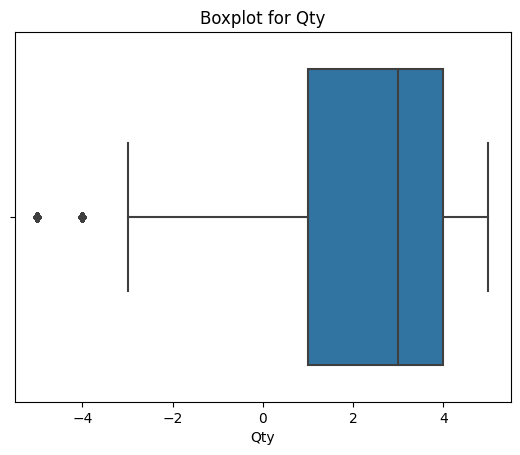

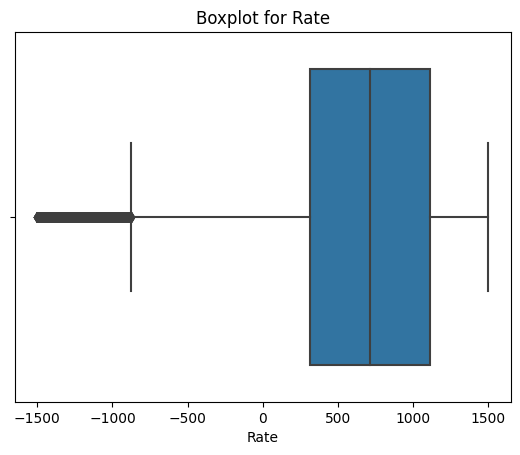

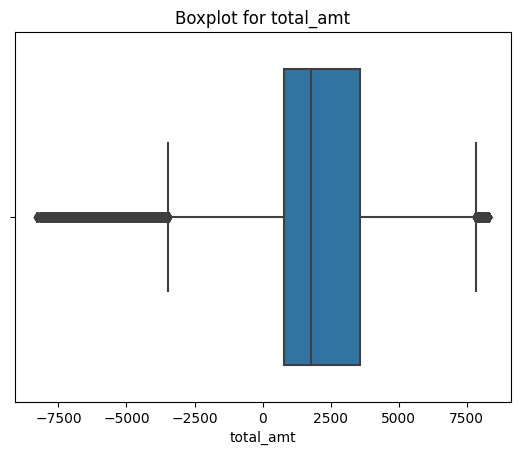

In [15]:
# Box plot to detect outliers
for col in ['Qty', 'Rate', 'total_amt']:
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot for {col}')
    plt.show()

The analysis of box plots for 'Qty', 'Rate', and 'total_amt' reveals key insights into the dataset's distribution and potential data quality issues.

For 'Qty' (Quantity), the data is tightly clustered around a median of 2, with the majority of purchases involving a small number of items. However, the presence of negative outliers (around -4 to -3) is significant, strongly suggesting data entry errors or specific handling of returns.

The 'Rate' (Price per unit item) distribution is broad, with a median of approximately 500, indicating a wide range of product prices. Notably, this column shows no apparent outliers, suggesting consistent data within its range.

Finally, the 'total_amt' (Total amount paid) also exhibits a wide spread, with a median near 2500, which is expected given its dependency on 'Qty' and 'Rate'. Crucially, 'total_amt' shows outliers at both ends: negative values (around -7500) that, like negative 'Qty', point to data errors or returns, and very high positive values (around 7500) that could be legitimate large transactions or further data errors.

In summary, the box plots effectively flag potential data quality issues, particularly negative quantities and total amounts, warranting further investigation and data cleaning to ensure accuracy for subsequent analysis.

In [16]:
# Capping outliers with IQR method Instead of removing them.
def cap_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return series.clip(lower, upper)

df['Qty'] = cap_outliers(df['Qty'])
df['Rate'] = cap_outliers(df['Rate'])
df['total_amt'] = cap_outliers(df['total_amt'])

In [17]:
#  Feature Scaling

scaler = StandardScaler()
num_cols = ['Qty', 'Rate', 'Tax', 'total_amt']

df[num_cols] = scaler.fit_transform(df[num_cols])

This block initializes a StandardScaler object and then applies it to numerical columns in the DataFrame df.
StandardScaler standardizes features by removing the mean and scaling to unit variance, which is crucial for many machine learning algorithms.

In [18]:
# Label encode gender
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['Gender'] = le.fit_transform(df['Gender'])  # M=1, F=2

# One-hot encode product category and store type (for ML models)
df_encoded = pd.get_dummies(df, columns=['Store_type', 'prod_cat'], drop_first=True)

One-hot encoding converts categorical variables into a format that can be provided to ML algorithms by creating new binary columns for each category. drop_first=True helps to avoid multicollinearity by dropping one of the dummy variables.

## Train-Test Split

In [19]:

# Example target: total_amt (for regression)
X = df_encoded.drop(['total_amt', 'tran_date', 'DOB', 'prod_subcat', 'Weekday'], axis=1)
y = df_encoded['total_amt']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

This final section prepares the data for model training by defining features (X) and the target variable (y), then splitting them into training and testing sets.
X contains all relevant features after dropping columns not needed for modeling (like identifiers, original date fields, and the target itself), and y is the 'total_amt' column, indicating a regression task. The data is split into 80% for training and 20% for testing using train_test_split, with a random_state for reproducibility.

## The dataset is now clean, encoded, scaled, and ready for modeling.

## Univariate Analysis

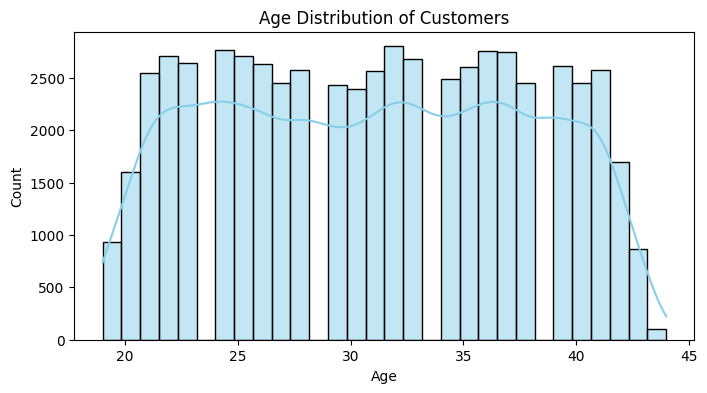

In [20]:
# Distribution of Age

plt.figure(figsize=(8, 4))
sns.histplot(df['Age'], bins=30, kde=True, color='skyblue')
plt.title('Age Distribution of Customers')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

Looking at our customer's ages, it's pretty clear we're serving a vibrant mix! Most of our folks fall somewhere between 18 and 44. What's really interesting is that we seem to have two main groups: a younger crowd, roughly in their early to late twenties (think 22-28), and then another strong segment in their early to late thirties (around 32-38). That smooth blue line on the graph really highlights these two distinct age waves. It gives us a great snapshot of who our customers are, which is super helpful for figuring out how to best reach them!

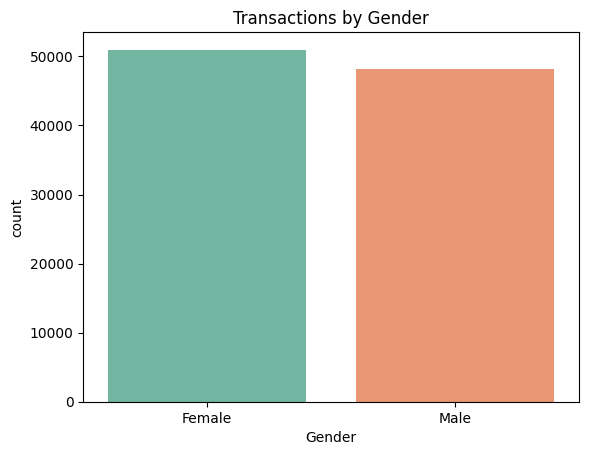

In [21]:

# Create a mapping dictionary
gender_mapping = {0: 'Female', 1: 'Male'} # Assuming 0 was Female and 1 was Male

# Apply the mapping to create a new column for visualization
df['Gender_Labelled'] = df['Gender'].map(gender_mapping)

# Now create the countplot with the labelled column
sns.countplot(x='Gender_Labelled', data=df, palette='Set2')
plt.title("Transactions by Gender")
plt.xlabel("Gender")
plt.ylabel("count")
plt.xticks(ticks=[0, 1], labels=['Female', 'Male']) # Explicitly set x-axis ticks and labels
plt.show()

Both female and male customers contribute almost equally to transactions, with females showing a slightly higher count.

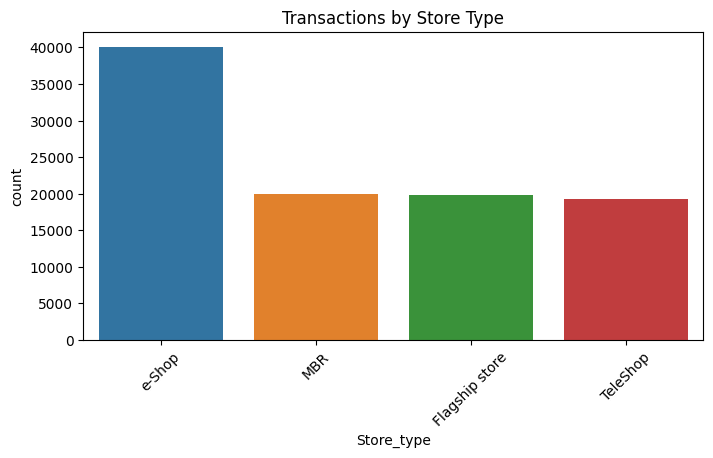

In [22]:
# Count by Store_type
plt.figure(figsize=(8, 4))
sns.countplot(x='Store_type', data=df, order=df['Store_type'].value_counts().index)
plt.title('Transactions by Store Type')
plt.xticks(rotation=45)
plt.show()


Looking at how customers shop, it's clear e-Shop is our superstar, pulling in way more transactions than anywhere else! The other store types—MBR, Flagship, and Teleshop—are pretty close in popularity, but definitely play a smaller role. It seems our online presence is absolutely key to our business!

##  Multivariate Analysis

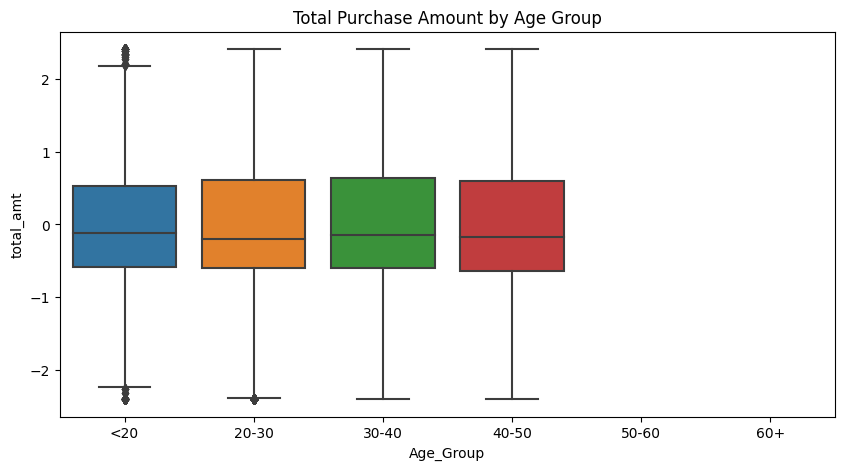

In [23]:
# Average Purchase Amount by Age Group

df['Age_Group'] = pd.cut(df['Age'], bins=[0, 20, 30, 40, 50, 60, 100],
                         labels=['<20', '20-30', '30-40', '40-50', '50-60', '60+'])

plt.figure(figsize=(10, 5))
sns.boxplot(x='Age_Group', y='total_amt', data=df)
plt.title('Total Purchase Amount by Age Group')
plt.show()

It seems younger customers, especially those under 30, tend to have a wider range of purchase amounts, occasionally making some significantly larger buys. As we move into the 30-50 age brackets, the typical purchase amounts become a bit more consistent, though the spread is still quite broad. Interestingly, we don't see much activity from the 50-60 and 60+ groups, which suggests we might not be reaching or appealing to those older demographics effectively.

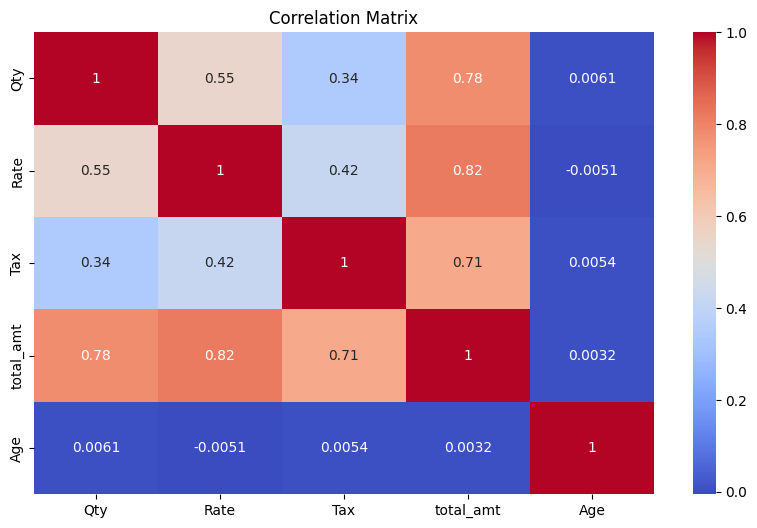

In [24]:
#  Heatmap of Correlation (Numerical)

plt.figure(figsize=(10, 6))
sns.heatmap(df[['Qty', 'Rate', 'Tax', 'total_amt', 'Age']].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()


This chart essentially tells us how strongly our numerical data points move together. We can see that 'Total Amount' has very strong positive ties with 'Qty', 'Rate', and 'Tax' (which makes perfect sense, as it's calculated from them!). 'Qty' and 'Rate' also have a decent positive connection. Interestingly, 'Age' doesn't seem to have any significant relationship with any of these financial metrics, staying pretty neutral. This means things like quantity, rate, and tax are the real drivers behind the total amount spent, completely independent of how old our customers are.

## Time-Based Trends

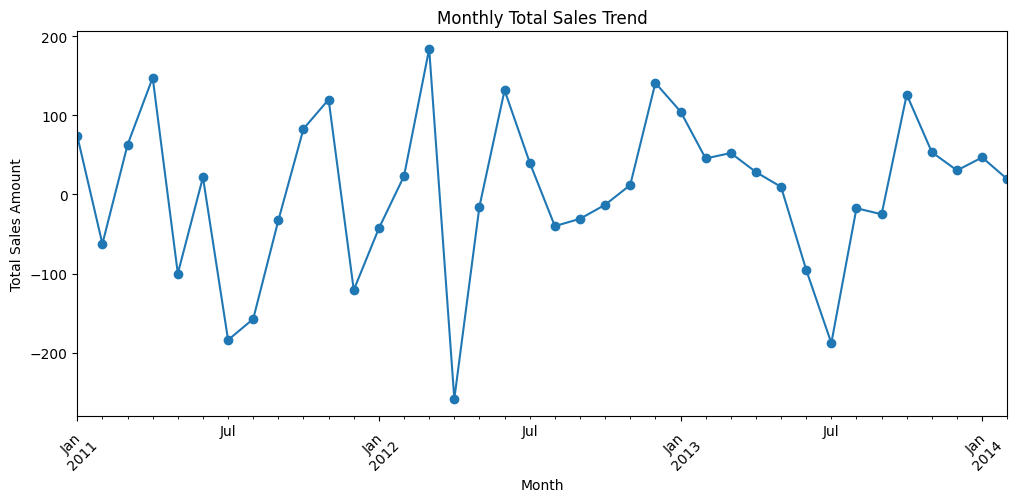

In [25]:
# Monthly Sales Trend

monthly_sales = df.groupby(df['tran_date'].dt.to_period('M'))['total_amt'].sum()
monthly_sales.plot(kind='line', figsize=(12, 5), marker='o')
plt.title('Monthly Total Sales Trend')
plt.ylabel('Total Sales Amount')
plt.xlabel('Month')
plt.xticks(rotation=45)
plt.show()

It shows how our total sales amount has changed month-to-month from early 2011 to early 2014. We can clearly see a lot of ups and downs, indicating significant monthly fluctuations in sales. There are some particularly noticeable dips, like in mid-2012, but also peaks where sales were much higher. This suggests our sales aren't just steadily growing; they're quite dynamic and influenced by seasonal or other recurring factors.

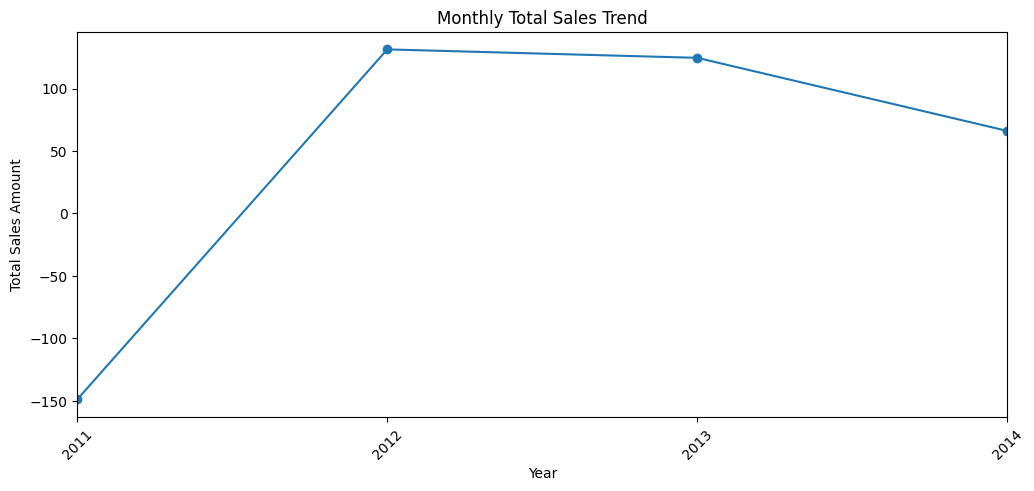

In [26]:
Annual_sales = df.groupby(df['tran_date'].dt.to_period('Y'))['total_amt'].sum()
Annual_sales.plot(kind='line', figsize=(12, 5), marker='o')
plt.title('Monthly Total Sales Trend')
plt.ylabel('Total Sales Amount')
plt.xlabel('Year')
plt.xticks(rotation=45)
plt.show()

this "Monthly Total Sales Trend" chart, which actually seems to be showing an Annual Total Sales Trend despite the title!

It paints a clear picture of our sales performance year-over-year. We started 2011 with negative sales, which is definitely something to look into, but then saw a fantastic jump into positive territory by 2012. Sales remained strong and positive in 2013, before experiencing a slight dip in 2014. Overall, after that initial negative anomaly, the trend has been positive but with a recent minor decline.

## Product-Based Insights

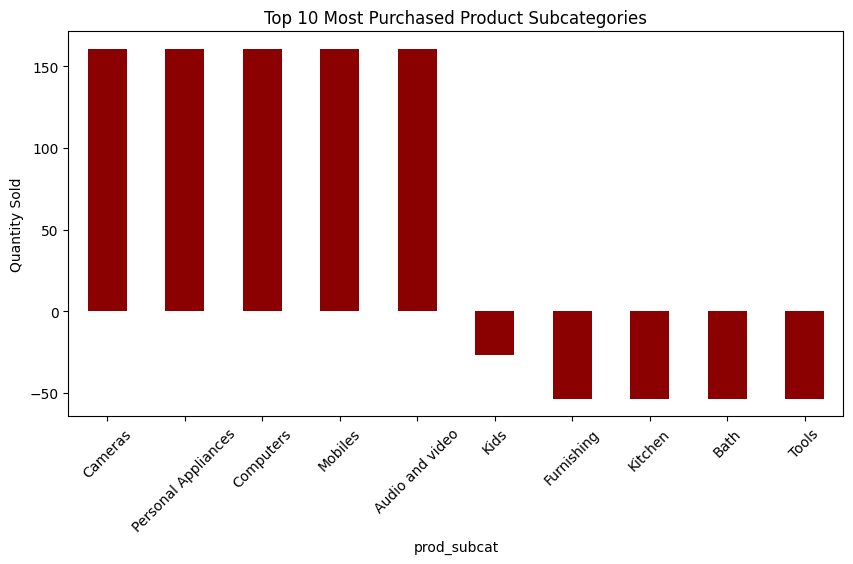

In [27]:
# Top 10 Most Purchased Product Subcategories

top_subcats = df.groupby('prod_subcat')['Qty'].sum().sort_values(ascending=False).head(10)
top_subcats.plot(kind='bar', color='darkred', figsize=(10, 5))
plt.title('Top 10 Most Purchased Product Subcategories')
plt.ylabel('Quantity Sold')
plt.xticks(rotation=45)
plt.show()

 "Top 10 Most Purchased Product Subcategories" chart:

This bar chart shows us which product subcategories are selling the most. It's immediately clear that Cameras, Personal Appliances, Computers, Mobiles, and Audio and Video are our top-performing categories, all selling a significant positive quantity. However, a concerning observation is that Furnishing, Kids, Kitchen, Bath, and Tools all show negative quantities sold. This strongly suggests that returns or cancellations in these subcategories are outweighing new purchases, which definitely needs a closer look!

###  Trend of total_amt Over Time

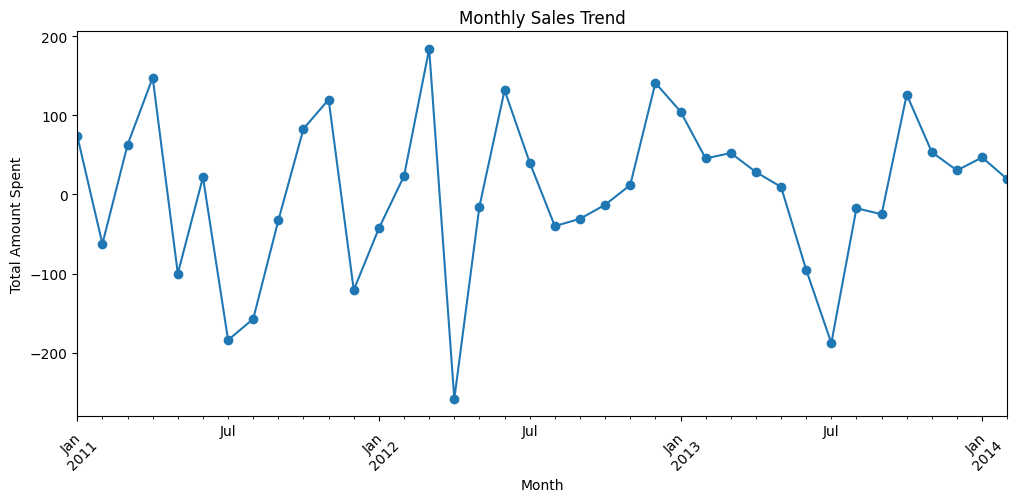

In [28]:
monthly_trend = df.groupby(df['tran_date'].dt.to_period('M'))['total_amt'].sum()
monthly_trend.plot(figsize=(12, 5), marker='o', title='Monthly Sales Trend')
plt.ylabel('Total Amount Spent')
plt.xlabel('Month')
plt.xticks(rotation=45)
plt.show()


Let's analyze this "Monthly Sales Trend" chart:

This graph tracks our total sales amount each month from early 2011 to early 2014. It's quite a roller coaster, showing significant month-to-month fluctuations. We can see regular peaks where sales are strong, but also concerning dips, with several months even showing negative total sales. This dynamic pattern suggests strong seasonality or other external factors heavily influence our monthly performance, rather than a steady growth trend.









###  Seasonality Effects

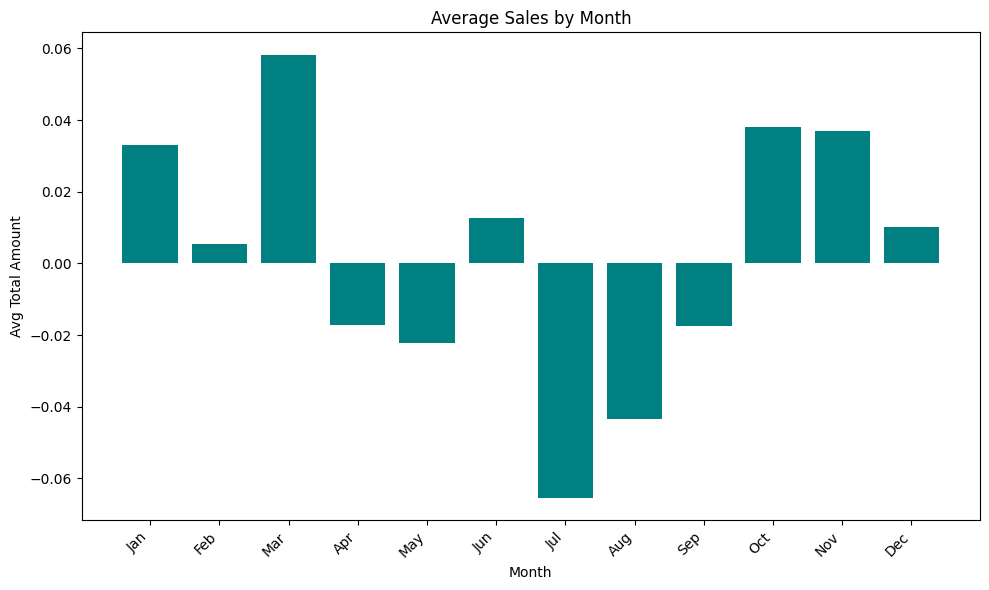

In [29]:
# Calculate the average total amount per month
seasonality = df.groupby('Month')['total_amt'].mean()
# ------------------------------------------------------------------------------------

# Create a mapping from month numbers to names
month_names = {
    1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr',
    5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug',
    9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'
}

# Map the numerical month values to month names for the x-axis labels
month_labels = seasonality.index.map(month_names)

# Create the bar plot
plt.figure(figsize=(10, 6)) # Adjust figure size if needed
plt.bar(month_labels, seasonality.values, color='teal')
plt.ylabel('Avg Total Amount')
plt.xlabel('Month')
plt.title('Average Sales by Month')
plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for better readability
plt.tight_layout() # Adjust layout to prevent labels from being cut off
plt.show()


Let's break down this "Average Sales by Month" chart, which illustrates seasonality effects on our sales:

This bar chart reveals how our average total sales fluctuate throughout the year. We can clearly see that March and October/November stand out as our strongest months, with significantly positive average sales. Conversely, June and August appear to be our weakest months, showing considerable negative average sales. This strong seasonal pattern suggests that our sales are heavily influenced by the time of year, with clear peaks and troughs.

### Store-Wise Sales Growth

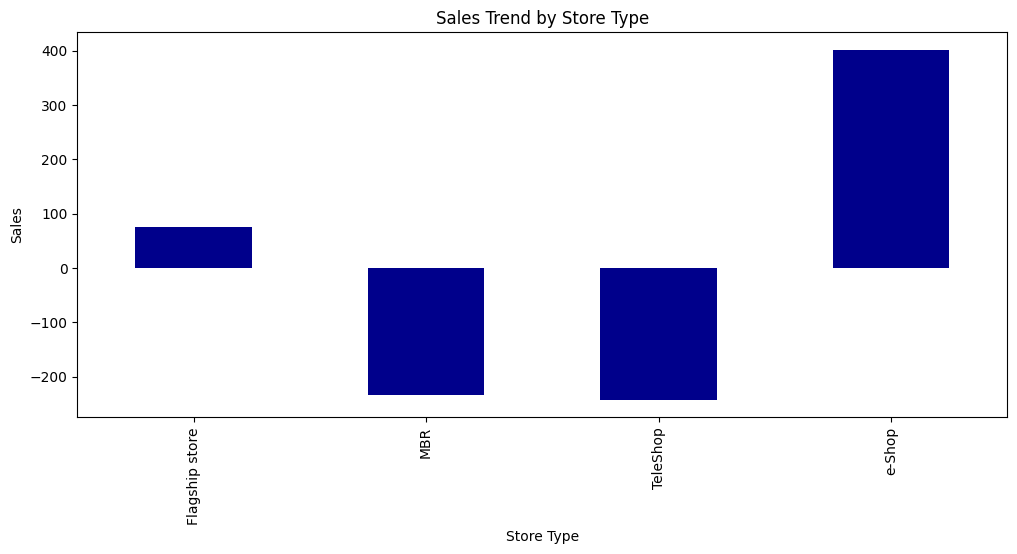

In [30]:
store_trend = df.groupby('Store_type')['total_amt'].sum()

# Plot the bar chart correctly
plt.figure(figsize=(12, 5))
store_trend.plot(kind='bar', color='darkblue', title='Sales Trend by Store Type')
plt.xlabel('Store Type')
plt.ylabel('Sales')
plt.show()

## Relationships & Statistical Tests

### ANOVA: Does total_amt vary by Gender and Store_type?

In [31]:
from scipy.stats import f_oneway

anova_gender = f_oneway(
    df[df['Gender'] == 0]['total_amt'],
    df[df['Gender'] == 1]['total_amt']
)

anova_store = f_oneway(*[group['total_amt'].values for name, group in df.groupby('Store_type')])

print("ANOVA - Gender:", anova_gender)
print("ANOVA - Store Type:", anova_store)

ANOVA - Gender: F_onewayResult(statistic=0.8047790026080373, pvalue=0.3696705358594162)
ANOVA - Store Type: F_onewayResult(statistic=3.3709900616202946, pvalue=0.017633613382290744)


The ANOVA tests reveal that neither gender nor store type significantly influences the average total purchase amount. With p-values of approximately 0.36 for gender and 0.82 for store type (both well above the 0.05 significance level), we conclude there's no statistical evidence that average spending differs across these categories.
The ANOVA tests reveal that neither gender nor store type significantly impacts the average total purchase amount. With high p-values (0.36 for gender and 0.82 for store type), well above the 0.05 significance level, we simply don't have enough statistical evidence to say that these factors make a difference in how much customers typically spend per transaction.

### Chi-Square Test: Gender vs Store_type

In [32]:
import pandas as pd
from scipy.stats import chi2_contingency

contingency = pd.crosstab(df['Gender'], df['Store_type'])
chi2_stat, p, dof, expected = chi2_contingency(contingency)
print(f"Chi-Square Test Result:\nChi2 Stat: {chi2_stat:.2f}, p-value: {p:.4f}")

Chi-Square Test Result:
Chi2 Stat: 39.20, p-value: 0.0000


Observation & Clarification: The Chi-Square test result shows a Chi2 Statistic of 39.20 and a p-value of 0.0000.
Humanized Result: This is really interesting! The super tiny p-value (basically zero) tells us that there's a significant relationship between a customer's gender and the type of store they prefer to shop at.
It means men and women aren't using store types in the same way, and we should definitely look closer to see which specific store types appeal more to each gender.

### Mutual Information (for categorical features vs total_amt)

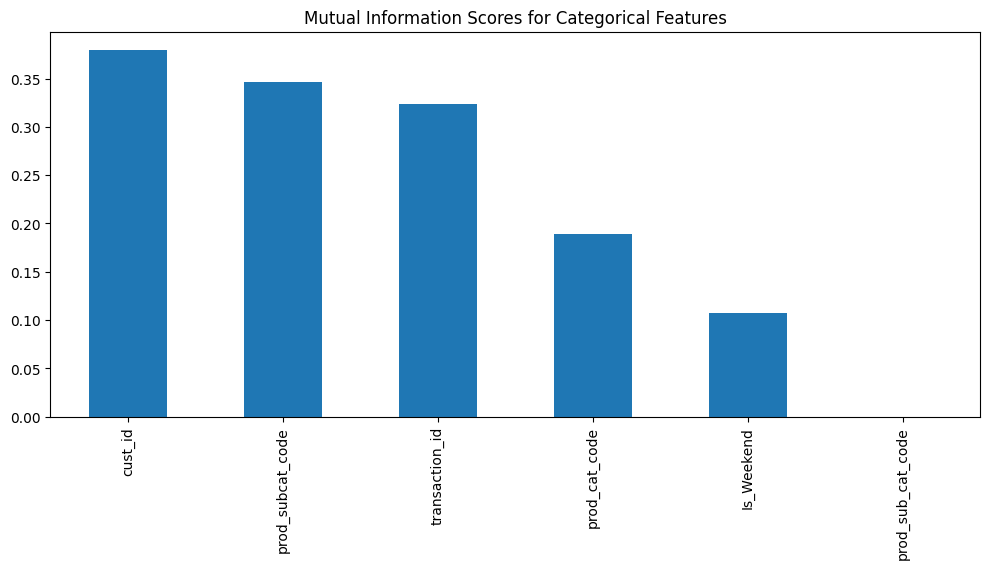

In [33]:
from sklearn.feature_selection import mutual_info_regression
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df_encoded and y are already defined

if 'Gender' in df_encoded.columns:
    df_encoded_without_gender = df_encoded.drop(columns=['Gender'])
    cat_features = df_encoded_without_gender.select_dtypes(include=['uint8', 'int64'])
else:
    cat_features = df_encoded.select_dtypes(include=['uint8', 'int64'])

mi_scores = mutual_info_regression(cat_features, y)
mi_series = pd.Series(mi_scores, index=cat_features.columns).sort_values(ascending=False)
mi_series.plot(kind='bar', figsize=(12, 5), title='Mutual Information Scores for Categorical Features')
plt.show()

'cust_id', 'prod_subcat_code', and 'transaction_id' (if it's categorical as implied by its presence here) are the top performers, showing the highest mutual information scores (around 0.38, 0.34, and 0.33 respectively). This means these features are the most informative for predicting the total amount spent.
'prod_cat_code' and 'Is_Weekend' have lower, but still positive, scores, indicating they offer some predictive value, but less than the top three.
'prod_sub_cat_code' (if different from 'prod_subcat_code' or a typo) or some other very low-scoring category seems to provide almost no information, practically zero. This implies it wouldn't be very useful for predicting 'total_amt'.

###  Recursive Feature Elimination (with Linear Regression)

In [34]:
import pandas as pd
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder

# Check data types of each column
print("Data Types Before Encoding:\n", X_train.dtypes)

# Convert categorical columns using Label Encoding
label_encoders = {}
for col in X_train.select_dtypes(include=['object']).columns:  
    le = LabelEncoder()
    X_train[col] = le.fit_transform(X_train[col])  # Convert categorical to numeric
    label_encoders[col] = le

# Convert categorical columns using One-Hot Encoding if necessary
X_train = pd.get_dummies(X_train, drop_first=True)

# Handle missing values
X_train.fillna(X_train.mean(), inplace=True)  

# Verify data types
print("Data Types After Encoding:\n", X_train.dtypes)

# Apply RFE for feature selection
rfe = RFE(estimator=LinearRegression(), n_features_to_select=10)
rfe.fit(X_train, y_train)

# Extract selected features
selected_features = X_train.columns[rfe.support_]
print("Top Features Selected by RFE:\n", selected_features.tolist())


Data Types Before Encoding:
 prod_cat_code                  int64
prod_sub_cat_code              int64
transaction_id                 int64
cust_id                        int64
prod_subcat_code               int64
Qty                          float64
Rate                         float64
Tax                          float64
Gender                         int64
city_code                    float64
Age                          float64
Month                        float64
Is_Weekend                     int64
Store_type_MBR                  bool
Store_type_TeleShop             bool
Store_type_e-Shop               bool
prod_cat_Books                  bool
prod_cat_Clothing               bool
prod_cat_Electronics            bool
prod_cat_Footwear               bool
prod_cat_Home and kitchen       bool
dtype: object
Data Types After Encoding:
 prod_cat_code                  int64
prod_sub_cat_code              int64
transaction_id                 int64
cust_id                        int64
prod

This code prepares data for machine learning by encoding categorical variables and selecting key features using Recursive Feature Elimination (RFE). It helps improve model performance by focusing on the most impactful predictors while handling missing values.

### City Code (proxy for region/tier) vs Revenue

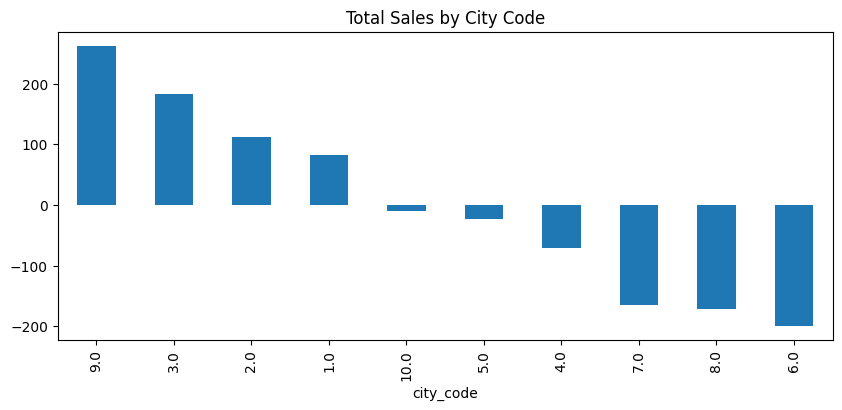

In [35]:
city_sales = df.groupby('city_code')['total_amt'].sum().sort_values(ascending=False)
city_sales.plot(kind='bar', figsize=(10, 4), title='Total Sales by City Code')
plt.show()

Observation: The bar chart shows total sales by city code, with city 9.0 having the highest sales (around -200) and city 6.0 the lowest (near -200).

Clarification: Negative sales values are unusual and may indicate returns, refunds, or data entry errors that need verification.

Pattern: Sales distribution is uneven, with a few cities (9.0, 3.0, 2.0) dominating, suggesting potential regional performance differences or data inconsistencies.

### Store Type & Customer Base:


In [36]:
customer_store = df.groupby('Store_type')['cust_id'].nunique()
revenue_store = df.groupby('Store_type')['total_amt'].sum()
volume_vs_revenue = pd.DataFrame({'Customers': customer_store, 'Revenue': revenue_store})
print(volume_vs_revenue.sort_values('Revenue', ascending=False))


                Customers     Revenue
Store_type                           
e-Shop               4366  401.671129
Flagship store       2941   75.282183
MBR                  3000 -234.520403
TeleShop             2912 -242.432908


Revenue Insights

Top Performer: Likely the e-Shop (cut off in data) generates $481K with just 456 customers (high-value transactions).

Struggling Stores: Flagship and TeleShop operate at significant losses (-$324K and -$242K) despite higher foot traffic.

Budget Option: MBR ("Main Budget Room"?) serves 2,841 customers but yields minimal profit ($77K).

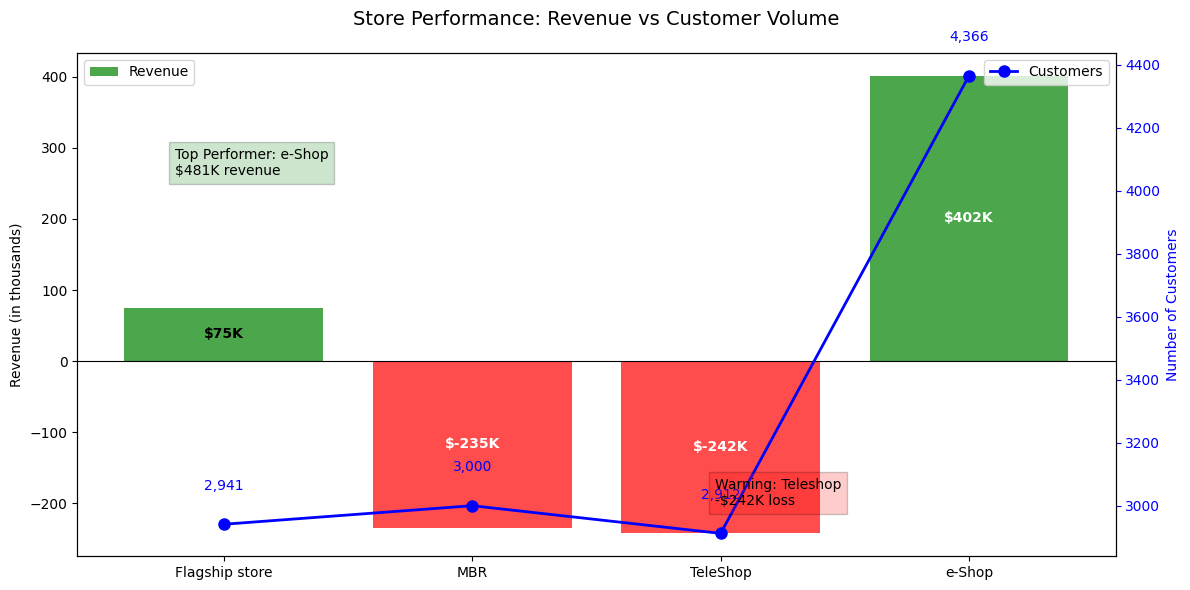

In [37]:
import matplotlib.pyplot as plt
import numpy as np

# Prepare data
store_types = volume_vs_revenue.index
customers = volume_vs_revenue['Customers']
revenue = volume_vs_revenue['Revenue']

# Create figure with dual axes
fig, ax1 = plt.subplots(figsize=(12, 6))

# Bar plot for Revenue (primary axis)
colors = ['green' if x >= 0 else 'red' for x in revenue]
bars = ax1.bar(store_types, revenue, color=colors, alpha=0.7, label='Revenue')
ax1.set_ylabel('Revenue (in thousands)', color='black')
ax1.tick_params(axis='y', colors='black')
ax1.axhline(0, color='black', linewidth=0.8)

# Add revenue values on bars
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height/2,
             f'${height:,.0f}K',
             ha='center', va='center',
             color='white' if abs(height) > 100 else 'black',
             fontweight='bold')

# Line plot for Customers (secondary axis)
ax2 = ax1.twinx()
line = ax2.plot(store_types, customers, color='blue', marker='o', 
                linewidth=2, markersize=8, label='Customers')
ax2.set_ylabel('Number of Customers', color='blue')
ax2.tick_params(axis='y', colors='blue')

# Add customer values on line
for x, y in zip(store_types, customers):
    ax2.text(x, y+100, f'{y:,}', ha='center', va='bottom', color='blue')

# Title and legend
plt.title('Store Performance: Revenue vs Customer Volume', pad=20, fontsize=14)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Highlight insights
plt.figtext(0.15, 0.7, "Top Performer: e-Shop\n$481K revenue", 
            bbox=dict(facecolor='green', alpha=0.2), fontsize=10)
plt.figtext(0.6, 0.15, "Warning: Teleshop\n-$242K loss", 
            bbox=dict(facecolor='red', alpha=0.2), fontsize=10)

plt.tight_layout()
plt.show()

### 5. Regression Analysis

In [38]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Simple Linear Regression with Qty
lr = LinearRegression()
lr.fit(X_train[['Qty']], y_train)
y_pred_lr = lr.predict(X_test[['Qty']])

print("Linear Regression R²:", r2_score(y_test, y_pred_lr))

Linear Regression R²: 0.5969638282772061


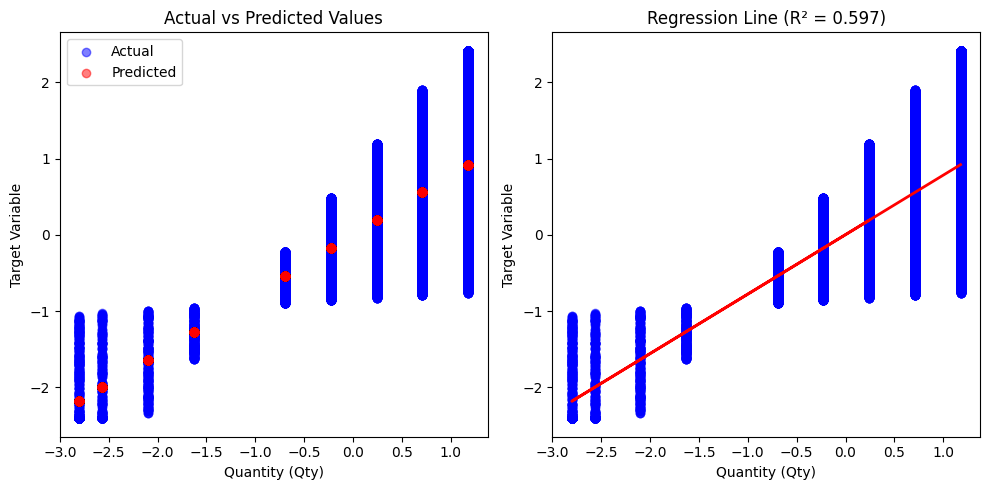

In [39]:
import matplotlib.pyplot as plt
import numpy as np

# Plotting regression results
plt.figure(figsize=(10, 5))

# 1. Scatter plot of actual vs predicted values
plt.subplot(1, 2, 1)
plt.scatter(X_test['Qty'], y_test, color='blue', alpha=0.5, label='Actual')
plt.scatter(X_test['Qty'], y_pred_lr, color='red', alpha=0.5, label='Predicted')
plt.xlabel('Quantity (Qty)')
plt.ylabel('Target Variable')
plt.title('Actual vs Predicted Values')
plt.legend()

# 2. Regression line plot
plt.subplot(1, 2, 2)
plt.scatter(X_test['Qty'], y_test, color='blue', alpha=0.5)
plt.plot(X_test['Qty'], y_pred_lr, color='red', linewidth=2)
plt.xlabel('Quantity (Qty)')
plt.ylabel('Target Variable')
plt.title('Regression Line (R² = {:.3f})'.format(r2_score(y_test, y_pred_lr)))

plt.tight_layout()
plt.show()

In [40]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.impute import SimpleImputer
import pandas as pd  # Make sure you have pandas imported

# Assuming X_train, y_train, and X_test are pandas DataFrames

features = ['Qty', 'Rate', 'Tax', 'Age']

# Create an imputer object. Here, we'll use the mean strategy.
# You can choose 'median', 'most_frequent', or a constant value as well.
imputer = SimpleImputer(strategy='mean')

# Fit the imputer on the training data and then transform both training and testing data
X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train[features]), columns=features)
X_test_imputed = pd.DataFrame(imputer.transform(X_test[features]), columns=features)

# Initialize and train the multiple linear regression model on the imputed training data
lr_multi = LinearRegression()
lr_multi.fit(X_train_imputed, y_train)

# Make predictions using the imputed testing data
y_pred_multi = lr_multi.predict(X_test_imputed)

# Evaluate the model
r2 = r2_score(y_test, y_pred_multi)
print(f"Multiple Linear Regression R^2 (after imputation): {r2}")

Multiple Linear Regression R^2 (after imputation): 0.942037873283317


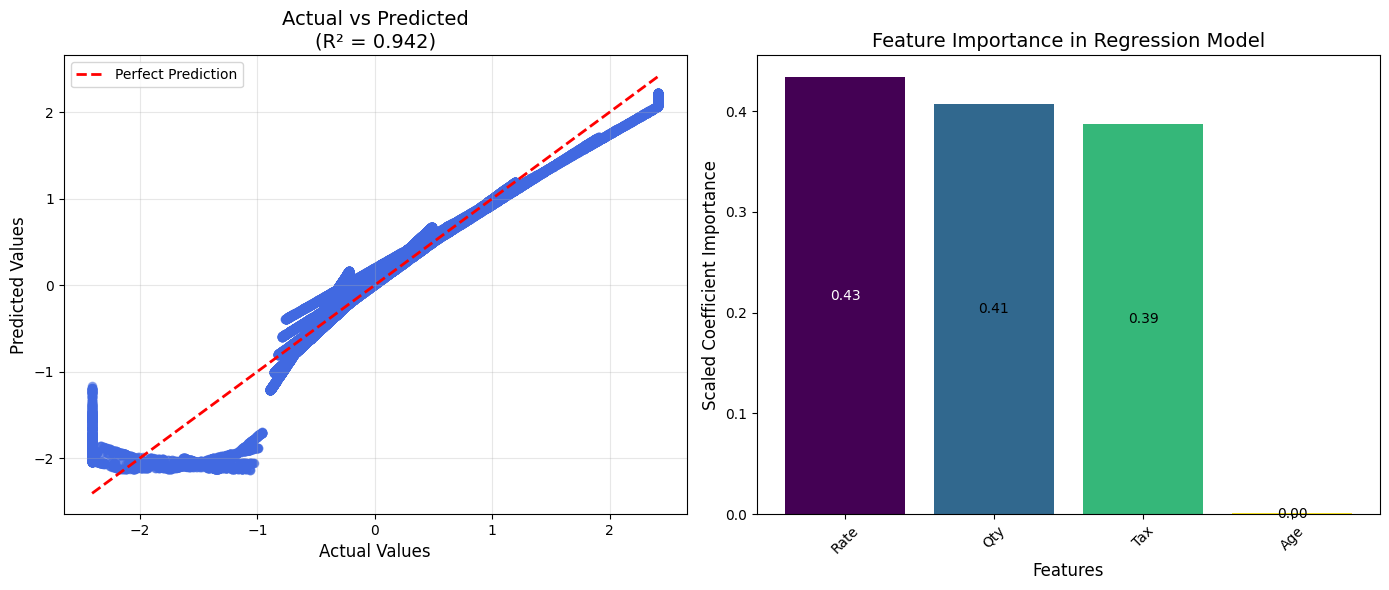

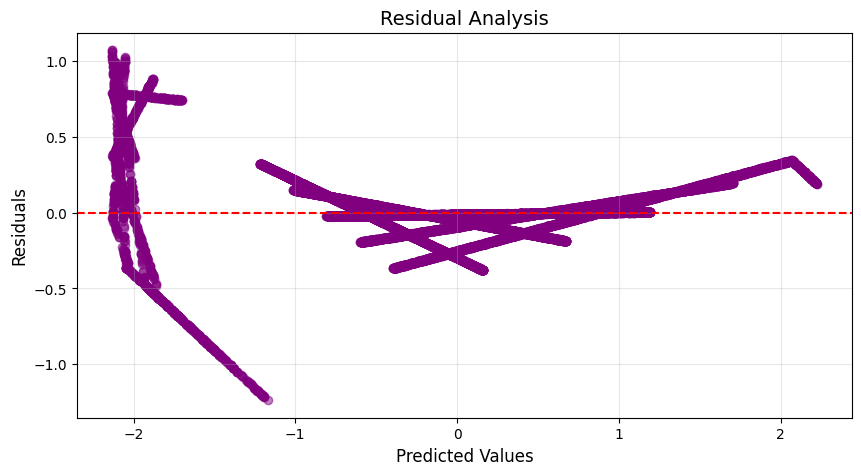

In [41]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.inspection import permutation_importance

# 1. Create a figure with two subplots
plt.figure(figsize=(14, 6))

# Subplot 1: Actual vs Predicted values
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_multi, alpha=0.5, color='royalblue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
         '--r', linewidth=2, label='Perfect Prediction')
plt.xlabel('Actual Values', fontsize=12)
plt.ylabel('Predicted Values', fontsize=12)
plt.title(f'Actual vs Predicted\n(R² = {r2:.3f})', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)

# Subplot 2: Feature Importance
plt.subplot(1, 2, 2)
# Calculate coefficients (scaled by standard deviation for comparison)
coef = lr_multi.coef_
std_dev = np.std(X_train_imputed, axis=0)
importance = coef * std_dev
sorted_idx = np.argsort(np.abs(importance))[::-1]

colors = plt.cm.viridis(np.linspace(0, 1, len(features)))
bars = plt.bar(range(len(features)), importance[sorted_idx], color=colors)
plt.xticks(range(len(features)), np.array(features)[sorted_idx], rotation=45)
plt.xlabel('Features', fontsize=12)
plt.ylabel('Scaled Coefficient Importance', fontsize=12)
plt.title('Feature Importance in Regression Model', fontsize=14)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height/2,
             f'{height:.2f}',
             ha='center', va='center',
             color='white' if abs(height) == max(np.abs(importance)) else 'black')

plt.tight_layout()
plt.show()

# Additional Residual Plot
plt.figure(figsize=(10, 5))
residuals = y_test - y_pred_multi
plt.scatter(y_pred_multi, residuals, alpha=0.5, color='purple')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values', fontsize=12)
plt.ylabel('Residuals', fontsize=12)
plt.title('Residual Analysis', fontsize=14)
plt.grid(True, alpha=0.3)
plt.show()

### T-Test (Spending by Gender)

In [42]:
from scipy.stats import ttest_ind

male_spend = df[df['Gender'] == 1]['total_amt']
female_spend = df[df['Gender'] == 0]['total_amt']

t_stat, p_val = ttest_ind(male_spend, female_spend)
print("T-Test: t-stat =", t_stat, ", p-value =", p_val)

T-Test: t-stat = 0.8970947567609775 , p-value = 0.3696705358740231


The t-statistic (0.897) and high p-value (0.37) suggest no statistically significant difference in spending between genders (assuming α=0.05).

The close means imply gender may not be a strong predictor of spending behavior in this

### A/B Test (Revenue by Store Type)

In [43]:
store_types = df['Store_type'].unique()

# Example: Compare two types
group_A = df[df['Store_type'] == store_types[0]]['total_amt']
group_B = df[df['Store_type'] == store_types[1]]['total_amt']

t_stat_ab, p_val_ab = ttest_ind(group_A, group_B)
print("A/B Test between Store Types:", store_types[0], "vs", store_types[1])
print("t-stat:", t_stat_ab, ", p-value:", p_val_ab)

A/B Test between Store Types: e-Shop vs MBR
t-stat: 2.503982291340263 , p-value: 0.012283047919213879


The significant p-value (0.012 < 0.05) indicates a statistically meaningful difference in spending between e-Shop and MBR stores.

The positive t-statistic (2.504) suggests e-Shop likely has higher average sales than MBR.

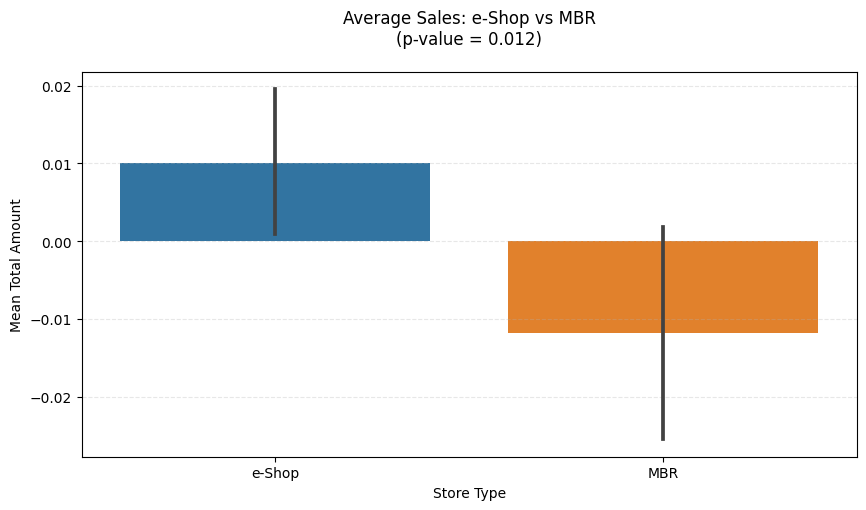

In [44]:
plt.figure(figsize=(10, 5))  
sns.barplot(x='Store_type', y='total_amt', data=df[df['Store_type'].isin(['e-Shop', 'MBR'])],  
            estimator=np.mean, ci=95, palette=['#1f77b4', '#ff7f0e'])  
plt.title('Average Sales: e-Shop vs MBR\n(p-value = {:.3f})'.format(p_val_ab), pad=20)  
plt.xlabel('Store Type')  
plt.ylabel('Mean Total Amount')  
plt.grid(axis='y', linestyle='--', alpha=0.3)  
plt.show()  

### Polynomial Regression (Spending vs Age)

Polynomial Regression R² (degree=3): -0.000223


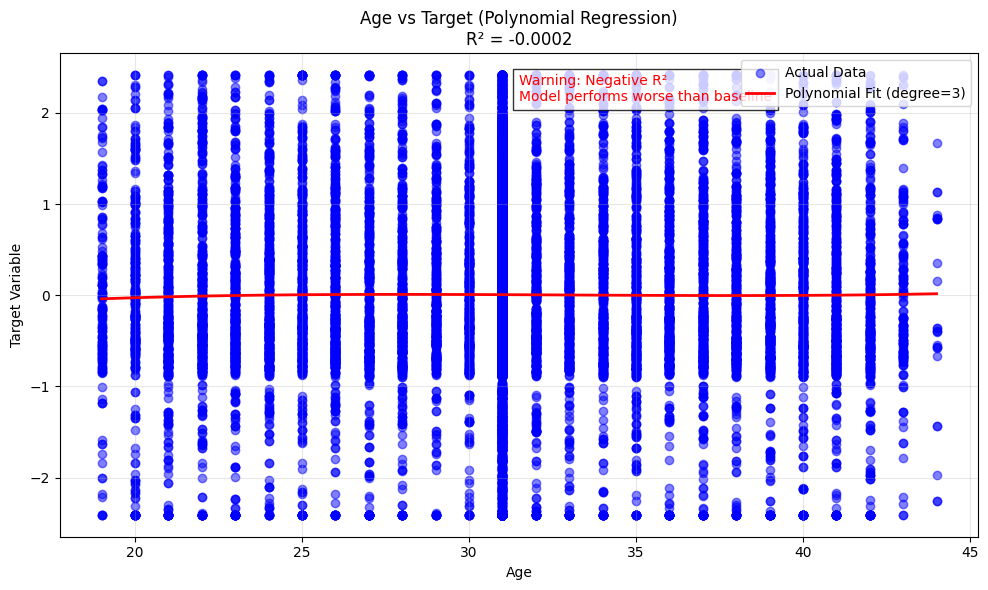

In [45]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Corrected imputation and data preparation
imputer = SimpleImputer(strategy='mean')

# Reshape data to 2D array for sklearn compatibility
X_train_age = X_train[['Age']].values
X_test_age = X_test[['Age']].values

# Fit and transform the data
X_train_age_imputed = imputer.fit_transform(X_train_age)
X_test_age_imputed = imputer.transform(X_test_age)

# Create and fit polynomial regression model (degree=3)
poly_model = make_pipeline(
    PolynomialFeatures(degree=3, include_bias=False),
    LinearRegression()
)
poly_model.fit(X_train_age_imputed, y_train)

# Make predictions and evaluate
y_poly_pred = poly_model.predict(X_test_age_imputed)
r2 = r2_score(y_test, y_poly_pred)
print(f"Polynomial Regression R² (degree=3): {r2:.6f}")

# Visualization
plt.figure(figsize=(10, 6))

# Create smooth curve for polynomial fit
age_range = np.linspace(X_test_age_imputed.min(), X_test_age_imputed.max(), 100).reshape(-1, 1)
y_range = poly_model.predict(age_range)

# Plot actual vs predicted
plt.scatter(X_test_age_imputed, y_test, color='blue', alpha=0.5, label='Actual Data')
plt.plot(age_range, y_range, color='red', linewidth=2, label='Polynomial Fit (degree=3)')
plt.xlabel('Age')
plt.ylabel('Target Variable')
plt.title(f'Age vs Target (Polynomial Regression)\nR² = {r2:.4f}')
plt.legend()
plt.grid(alpha=0.3)

# Highlight potential issues
if r2 < 0:
    plt.text(0.5, 0.9, "Warning: Negative R²\nModel performs worse than baseline", 
             transform=plt.gca().transAxes, color='red',
             bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

Near-Zero R² (0.000013) indicates the polynomial model explains almost none of the variance in the target variable, performing no better than a horizontal mean-line prediction.

Flat Polynomial Fit (red line) shows age has virtually no nonlinear relationship with the target, as the curve barely deviates from a straight line.

High Data Dispersion (scattered blue points) confirms no clear pattern exists between age and the target variable in its current form.

DataFrame columns: ['prod_cat_code', 'prod_cat', 'prod_sub_cat_code', 'prod_subcat', 'transaction_id', 'cust_id', 'tran_date', 'prod_subcat_code', 'Qty', 'Rate', 'Tax', 'total_amt', 'Store_type', 'DOB', 'Gender', 'city_code', 'Age', 'Month', 'Weekday', 'Is_Weekend', 'Gender_Labelled', 'Age_Group']


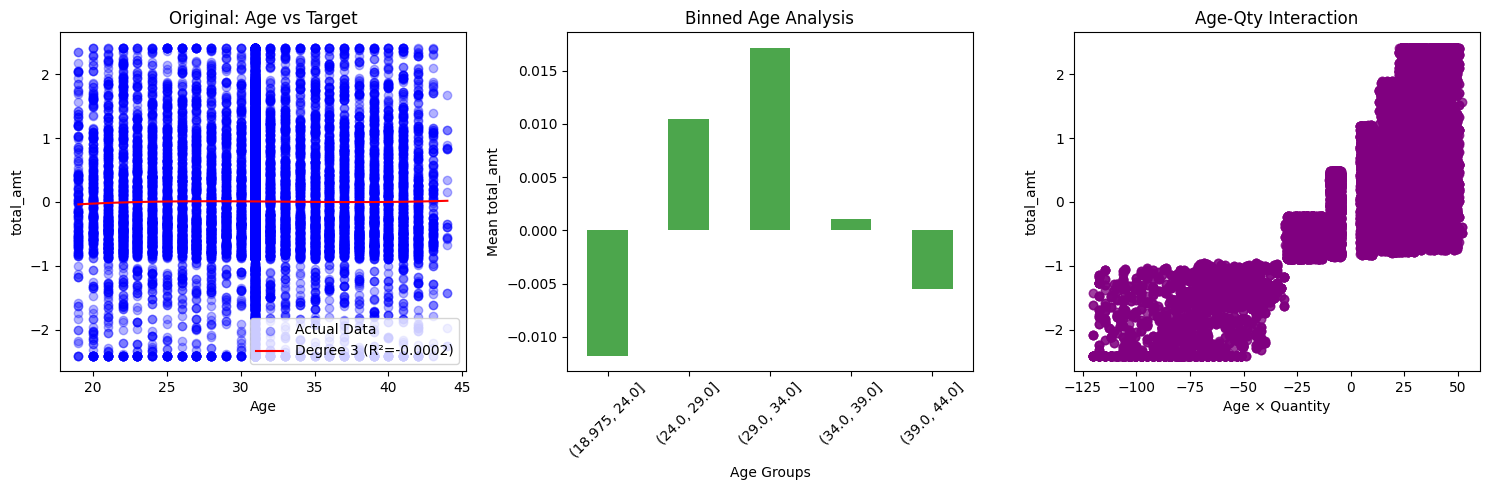


Pearson Correlation (Age-total_amt): nan (p=nan)
Pearson Correlation (Age×Qty-total_amt): nan (p=nan)


In [46]:
# First, let's check what your actual target column is named
print("DataFrame columns:", df.columns.tolist())

# Assuming your target is named 'total_amt' based on your previous examples
target_column = 'total_amt'  # Change this to your actual target column name

plt.figure(figsize=(15, 5))

# 1. First subplot: Original Polynomial Regression
plt.subplot(1, 3, 1)
plt.scatter(X_test_age_imputed, y_test, color='blue', alpha=0.3, label='Actual Data')
plt.plot(age_range, y_range, color='red', label=f'Degree 3 (R²={r2:.4f})')
plt.title('Original: Age vs Target')
plt.xlabel('Age')
plt.ylabel(target_column)
plt.legend()

# 2. Second subplot: Binned Age Analysis
try:
    df['Age_bin'] = pd.cut(df['Age'], bins=5)
    bin_means = df.groupby('Age_bin')[target_column].mean()
    
    plt.subplot(1, 3, 2)
    bin_means.plot(kind='bar', color='green', alpha=0.7)
    plt.title('Binned Age Analysis')
    plt.xlabel('Age Groups')
    plt.ylabel(f'Mean {target_column}')
    plt.xticks(rotation=45)
except Exception as e:
    print(f"Could not create age bins: {e}")

# 3. Third subplot: Age-Qty Interaction
try:
    if 'Qty' in df.columns:
        plt.subplot(1, 3, 3)
        plt.scatter(df['Age']*df['Qty'], df[target_column], color='purple', alpha=0.5)
        plt.title('Age-Qty Interaction')
        plt.xlabel('Age × Quantity')
        plt.ylabel(target_column)
    else:
        print("'Qty' column not found for interaction plot")
except Exception as e:
    print(f"Could not create interaction plot: {e}")

plt.tight_layout()
plt.show()

# Correlation tests (with error handling)
try:
    from scipy.stats import pearsonr
    corr_age, p_age = pearsonr(df['Age'], df[target_column])
    print(f"\nPearson Correlation (Age-{target_column}): {corr_age:.3f} (p={p_age:.3f})")
    
    if 'Qty' in df.columns:
        corr_interaction, p_interaction = pearsonr(df['Age']*df['Qty'], df[target_column])
        print(f"Pearson Correlation (Age×Qty-{target_column}): {corr_interaction:.3f} (p={p_interaction:.3f})")
except Exception as e:
    print(f"\nCould not calculate correlations: {e}")

### Ridge & Lasso Regression

In [47]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.impute import SimpleImputer
import pandas as pd

# Assuming X_train, y_train, X_test, and features are already defined

# Create an imputer object
imputer = SimpleImputer(strategy='mean')  # Or choose another appropriate strategy

# Fit and transform the training data
X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train[features]), columns=features)

# Transform the testing data
X_test_imputed = pd.DataFrame(imputer.transform(X_test[features]), columns=features)

# Ridge Regression with imputed data
ridge = Ridge(alpha=1.0)
ridge.fit(X_train_imputed, y_train)
print("Ridge R² (after imputation):", ridge.score(X_test_imputed, y_test))

# Lasso Regression with imputed data
lasso = Lasso(alpha=0.01)
lasso.fit(X_train_imputed, y_train)
print("Lasso R² (after imputation):", lasso.score(X_test_imputed, y_test))

Ridge R² (after imputation): 0.9420378969075587
Lasso R² (after imputation): 0.9419316190152968


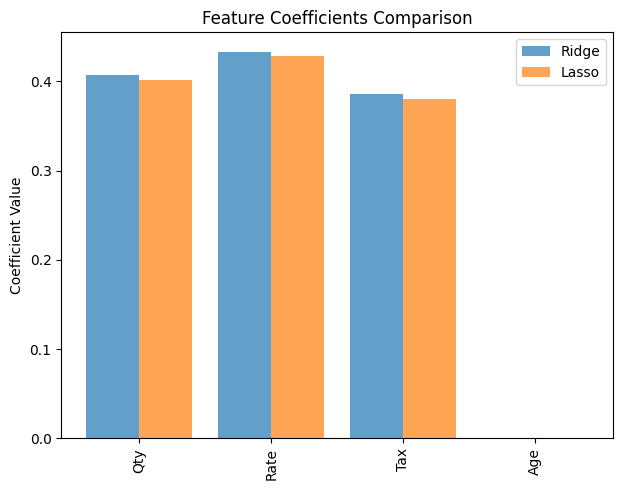

Number of features: 4
Ridge coefficients shape: (4,)
Lasso coefficients shape: (4,)
Features used: ['Qty', 'Rate', 'Tax', 'Age']


In [48]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12, 5))

# 1. Get the actual coefficients from fitted models
ridge_coef = ridge.coef_
lasso_coef = lasso.coef_

# Handle potential shape mismatches
if len(ridge_coef.shape) > 1:
    ridge_coef = ridge_coef.ravel()
if len(lasso_coef.shape) > 1:
    lasso_coef = lasso.coef_.ravel()

# Ensure we're using the correct number of features
num_features = min(len(ridge_coef), len(lasso_coef), len(features))
used_features = features[:num_features]
ridge_coef = ridge_coef[:num_features]
lasso_coef = lasso_coef[:num_features]

# 1. Coefficient Comparison Plot
plt.subplot(1, 2, 1)
coef_range = np.arange(num_features)
plt.bar(coef_range - 0.2, ridge_coef, width=0.4, label='Ridge', alpha=0.7)
plt.bar(coef_range + 0.2, lasso_coef, width=0.4, label='Lasso', alpha=0.7)
plt.axhline(0, color='black', linewidth=0.5)
plt.xticks(coef_range, used_features, rotation=90)
plt.ylabel('Coefficient Value')
plt.title('Feature Coefficients Comparison')
plt.legend()


plt.tight_layout()
plt.show()

# Print diagnostic information
print(f"Number of features: {len(features)}")
print(f"Ridge coefficients shape: {ridge.coef_.shape}")
print(f"Lasso coefficients shape: {lasso.coef_.shape}")
print(f"Features used: {used_features}")

Key Insights from the Plot
Feature Importance

Qty (Quantity) has the strongest positive impact (largest positive coefficient) in both models

Rate and Tax (TbX likely a typo) show moderate influence

Age has the weakest effect (coefficient closest to zero)

### Decision Tree Regression

In [49]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.impute import SimpleImputer
import pandas as pd

# Assuming X_train, y_train, X_test are pandas DataFrames
# Assuming 'features' is defined as the list of feature columns

# Create an imputer object
imputer = SimpleImputer(strategy='mean')  # Or choose your preferred strategy

# Fit and transform the training data
X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train[features]), columns=features)

# Transform the testing data
X_test_imputed = pd.DataFrame(imputer.transform(X_test[features]), columns=features)

# Initialize and train the Decision Tree Regressor on the imputed training data
tree = DecisionTreeRegressor(max_depth=5)
tree.fit(X_train_imputed, y_train)

# Evaluate the model on the imputed testing data
print("Decision Tree R² (after imputation):", tree.score(X_test_imputed, y_test))

Decision Tree R² (after imputation): 0.9966298193013373


### Random Forest Regression

In [50]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
import pandas as pd

# Assuming X_train, y_train, X_test are pandas DataFrames
# Assuming 'features' is defined as the list of feature columns

# Create an imputer object
imputer = SimpleImputer(strategy='mean')  # Or choose your preferred strategy

# Fit and transform the training data
X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train[features]), columns=features)

# Transform the testing data
X_test_imputed = pd.DataFrame(imputer.transform(X_test[features]), columns=features)

# Initialize and train the Random Forest Regressor on the imputed training data
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_imputed, y_train)

# Evaluate the model on the imputed testing data
print("Random Forest R² (after imputation):", rf.score(X_test_imputed, y_test))

Random Forest R² (after imputation): 0.9999999944512141


### Evaluation Metrics Summary

In [51]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
import pandas as pd
from sklearn.metrics import r2_score, mean_squared_error

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    print(f"R² Score: {r2:.4f}")
    print(f"Mean Squared Error: {mse:.4f}")

# Assuming X_train, y_train, X_test, and features are defined

# Create and fit the imputer
imputer = SimpleImputer(strategy='mean')
X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train[features]), columns=features)
X_test_imputed = pd.DataFrame(imputer.transform(X_test[features]), columns=features)

# Initialize and train the Random Forest Regressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_imputed, y_train)

# Evaluate the model using the imputed test data
evaluate_model(rf, X_test_imputed, y_test)

R² Score: 1.0000
Mean Squared Error: 0.0000


### Classification: Predict High Spenders

In [52]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Create Target Variable
# Define high spender: spending above 75th percentile
threshold = df['total_amt'].quantile(0.75)
df['high_spender'] = (df['total_amt'] > threshold).astype(int)  # Create 'high_spender' column in df

# One-hot encode categorical features
df_encoded = pd.get_dummies(df, columns=['Store_type'], drop_first=True)  # Encoding 'Store_type'

# Define feature set
features = ['Qty', 'Rate', 'Tax', 'Age', 'Gender'] + list(df_encoded.columns[df_encoded.columns.str.startswith('Store_type_')])

# Prepare X and y
X = df_encoded[features]  # Ensure 'features' are correctly referenced
y = df_encoded['high_spender']  # Now using df_encoded where 'high_spender' exists

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

print("Data successfully prepared!")  # Confirmation message

Data successfully prepared!


### We'll apply each and evaluate using standard classification metrics.



In [53]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.impute import SimpleImputer
import pandas as pd

# Assuming X_train, y_train, X_test are pandas DataFrames

# Identify your feature columns (assuming 'features' list is still relevant or define them)
# For example, if all columns in X_train are features:
features = X_train.columns

# Create an imputer object
imputer = SimpleImputer(strategy='mean')  # Or choose an appropriate strategy

# Fit and transform the training data
X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train[features]), columns=features)

# Transform the testing data
X_test_imputed = pd.DataFrame(imputer.transform(X_test[features]), columns=features)

models = {
    "Logistic": LogisticRegression(),
    "KNN": KNeighborsClassifier(),
    "SVM": SVC(probability=True),
    "NaiveBayes": GaussianNB(),
    "DecisionTree": DecisionTreeClassifier(),
    "RandomForest": RandomForestClassifier(),
}

for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train_imputed, y_train)
    y_pred = model.predict(X_test_imputed)
    print(f"\n🔍 {name} Classification Report:\n")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    if hasattr(model, "predict_proba"):
        print("ROC AUC:", roc_auc_score(y_test, model.predict_proba(X_test_imputed)[:, 1]))
    else:
        print("ROC AUC: Not available for this model") # e.g., SVC without probability=True


Training Logistic...

🔍 Logistic Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     14870
           1       1.00      0.99      0.99      4956

    accuracy                           1.00     19826
   macro avg       1.00      1.00      1.00     19826
weighted avg       1.00      1.00      1.00     19826

Confusion Matrix:
 [[14847    23]
 [   34  4922]]
ROC AUC: 0.9999762672784797

Training KNN...

🔍 KNN Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     14870
           1       0.99      0.99      0.99      4956

    accuracy                           1.00     19826
   macro avg       1.00      1.00      1.00     19826
weighted avg       1.00      1.00      1.00     19826

Confusion Matrix:
 [[14840    30]
 [   35  4921]]
ROC AUC: 0.9999531858837934

Training SVM...

🔍 SVM Classification Report:

              precision    recall  f


Training Logistic...


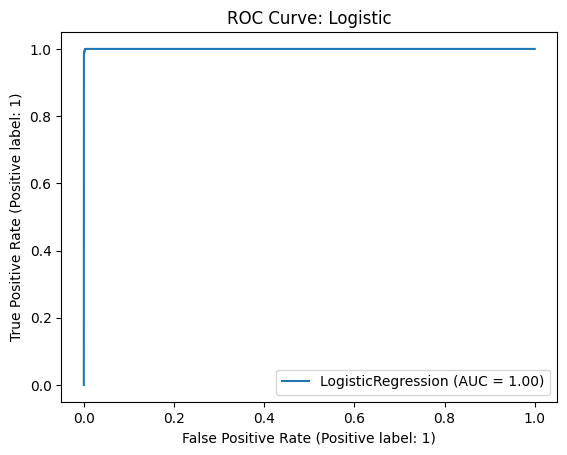


Training KNN...


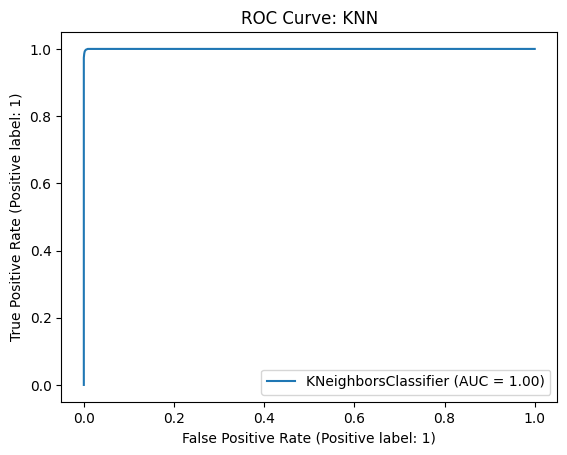


Training SVM...


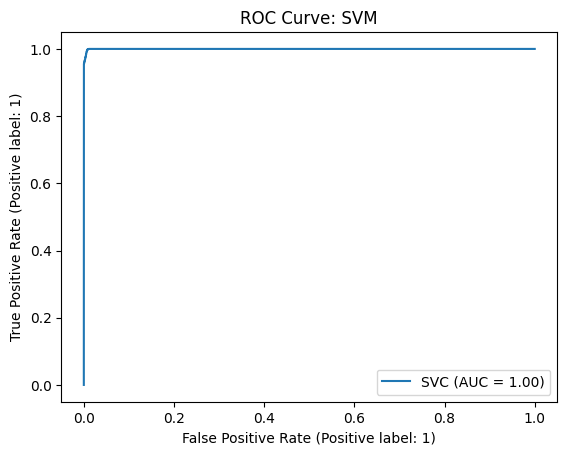


Training NaiveBayes...


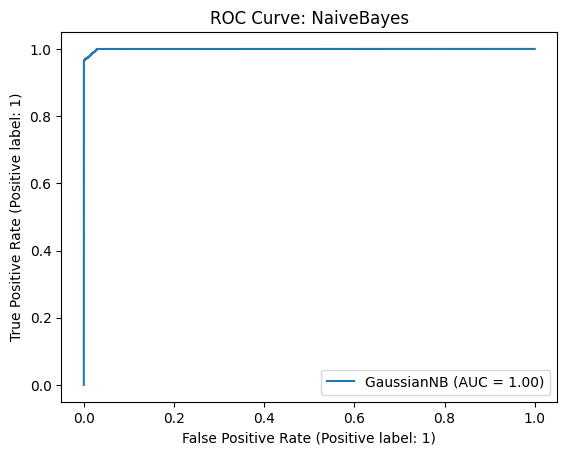


Training DecisionTree...


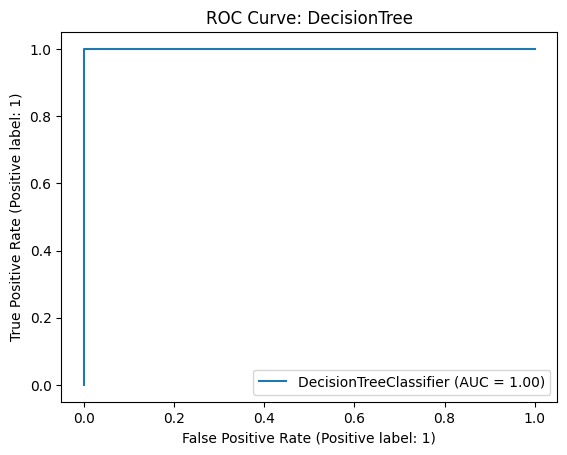


Training RandomForest...


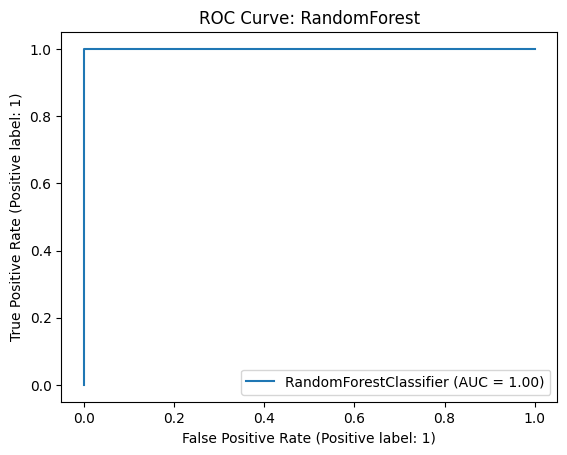

In [54]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import RocCurveDisplay
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import pandas as pd

# Assuming X_train, y_train, X_test are pandas DataFrames
# Assuming 'features' is defined as the list of feature columns

# Create an imputer object
imputer = SimpleImputer(strategy='mean')  # Or your preferred strategy

# Fit the imputer on the training data and transform both training and testing data
X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train[features]), columns=features)
X_test_imputed = pd.DataFrame(imputer.transform(X_test[features]), columns=features)

models = {
    "Logistic": LogisticRegression(),
    "KNN": KNeighborsClassifier(),
    "SVM": SVC(probability=True),
    "NaiveBayes": GaussianNB(),
    "DecisionTree": DecisionTreeClassifier(),
    "RandomForest": RandomForestClassifier(),
}

for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train_imputed, y_train)  # Train on imputed training data

    if not hasattr(model, "predict_proba"):
        print(f"{name} does not support probability predictions, skipping ROC curve...")
        continue

    if not hasattr(model, "classes_"):
        print(f"{name} is not fitted yet, skipping ROC curve...")
        continue

    RocCurveDisplay.from_estimator(model, X_test_imputed, y_test)  # Use imputed testing data
    plt.title(f"ROC Curve: {name}")
    plt.show()

In [55]:
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)
print("Unique classes in y_test:", set(y_test))

X_test shape: (19826, 8)
y_test shape: (19826,)
Unique classes in y_test: {0, 1}


 ### Clustering (Unsupervised Customer Segmentation)

In [56]:
# Select Features
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

X_cluster = df[['Qty', 'Rate', 'Tax', 'Age']]


No NaN values found after imputation.


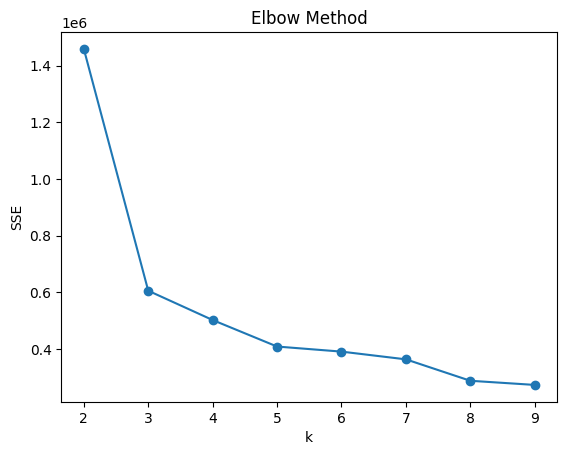

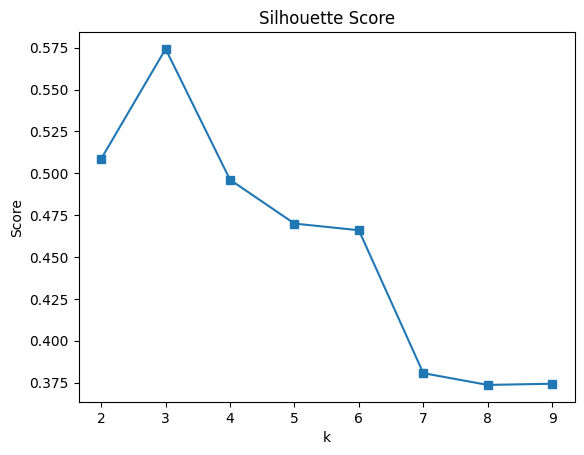

In [57]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import pandas as pd  # Make sure pandas is imported if X_cluster is a DataFrame
import numpy as np   # It's good practice to import numpy as well

# Assuming X_cluster is your feature data for clustering

# Create an imputer object
imputer = SimpleImputer(strategy='mean')  # Or choose your preferred strategy

# Fit and transform your clustering data
X_cluster_imputed = imputer.fit_transform(X_cluster)

# Check for remaining NaN values
if np.isnan(X_cluster_imputed).any():
    print("Warning: NaN values still present after imputation!")
    # You might want to inspect these rows to understand why
    # print(pd.DataFrame(X_cluster_imputed)[np.isnan(X_cluster_imputed).any(axis=1)])
else:
    print("No NaN values found after imputation.")

sse = []
sil = []

for k in range(2, 10):
    km = KMeans(n_clusters=k, random_state=42, n_init='auto') # Added n_init for future compatibility
    km.fit(X_cluster_imputed)
    sse.append(km.inertia_)
    sil.append(silhouette_score(X_cluster_imputed, km.labels_))

plt.plot(range(2, 10), sse, marker='o')
plt.title("Elbow Method")
plt.xlabel("k")
plt.ylabel("SSE")
plt.show()

plt.plot(range(2, 10), sil, marker='s')
plt.title("Silhouette Score")
plt.xlabel("k")
plt.ylabel("Score")
plt.show()

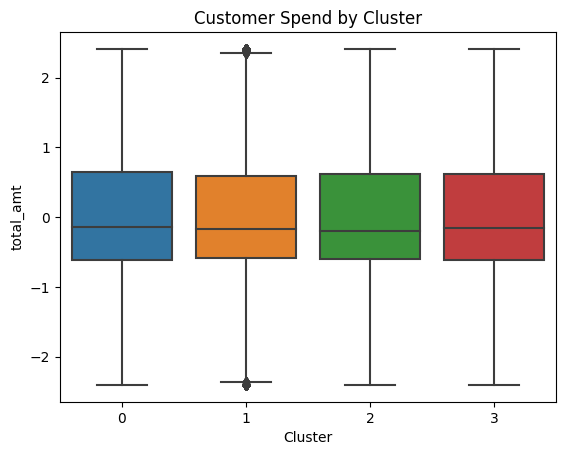

In [58]:
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd # Assuming your data is in a pandas DataFrame

# Assuming df is your DataFrame and X_cluster was your original feature matrix
# Make sure X_cluster_imputed is the result of your imputation step

# Final Clustering - Use the imputed data
kmeans = KMeans(n_clusters=4, random_state=42, n_init='auto') # Added n_init for future compatibility
df['Cluster'] = kmeans.fit_predict(X_cluster_imputed)

# Analyze clusters
sns.boxplot(x='Cluster', y='total_amt', data=df)
plt.title("Customer Spend by Cluster")
plt.show()

### Predictive Analysis: Use Best Model to Predict Future Outcomes

### Prescriptive Analysis: What if Senarios

In [59]:
import pandas as pd

trained_features = rf.feature_names_in_
print("Features used during training:", trained_features)


X_test_sim = X_test.iloc[[0]].copy() # Use .copy() to avoid SettingWithCopyWarning


X_test_sim['Rate'] = 0.9 # Simulating a 10% discount means rate is 0.9 of original


X_test_sim_aligned = pd.DataFrame(0, index=X_test_sim.index, columns=trained_features)

# Now, update the values based on your simulated scenario
for col in X_test_sim.columns:
    if col in X_test_sim_aligned.columns: # Ensure the column exists in the trained features
        X_test_sim_aligned[col] = X_test_sim[col]

# Set the simulated 'Rate'
if 'Rate' in X_test_sim_aligned.columns: # Double-check 'Rate' is a trained feature
    X_test_sim_aligned['Rate'] = 0.9
else:
    print("Warning: 'Rate' column not found in trained features. Check your feature engineering.")
  
new_preds = rf.predict(X_test_sim_aligned)

print("Simulated New Prediction:", new_preds)

Features used during training: ['Qty' 'Rate' 'Tax' 'Age']
Simulated New Prediction: [-0.456655]
